In [168]:
import msprime
from IPython.display import SVG, display
import networkx as nx
import jax
import jax.numpy as nmp
from jax.nn import log_softmax
import equinox as eqx
import itertools as it
import optax
import tskit
import numpy as np
from collections import defaultdict

In [189]:
ts = msprime.sim_ancestry(
        samples=4,
        recombination_rate=1e-8,
        sequence_length=20_000,
        population_size=8_000)
mts = msprime.sim_mutations(ts, rate = 1e-8)
sparse_genotype = mts.genotype_matrix().T
breakpoints = list(mts.breakpoints())
mutation_sites = [site.position for site in mts.sites()]

In [203]:
tree = ts.at_index(0)
dod = tree.as_dict_of_dicts()
tree_graph = nx.Graph(dod)
edge_pairs = list(tree_graph.edges)
edge_pairs_backwards = [t[::-1] for t in edge_pairs]
senders, receivers = zip(*edge_pairs_backwards)
senders = nmp.array(senders)
receivers = nmp.array(receivers)
N = max(list(tree_graph.nodes)) + 1
receivers

Array([25, 25, 15, 15,  9,  9,  8,  8, 23, 23, 10, 10, 13, 13], dtype=int32)

In [191]:
A = nmp.zeros((N, N))
A = A.at[senders, receivers].set(1)
A = A.at[receivers, senders].set(1)

In [192]:
edges = nmp.array(edge_pairs_backwards, dtype=nmp.int32)
edges[:, 1]

Array([25, 25, 15, 15,  9,  9,  8,  8, 23, 23, 10, 10, 13, 13], dtype=int32)

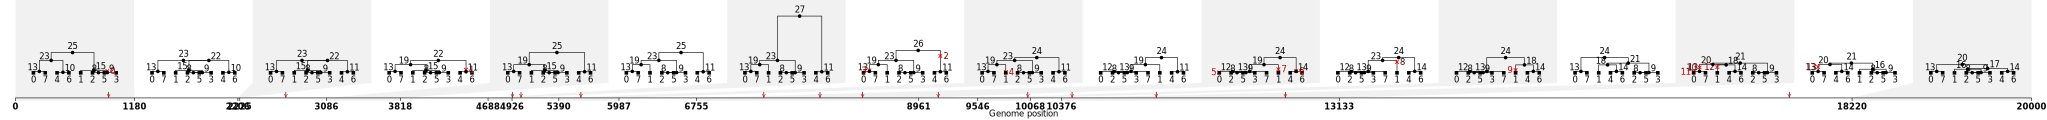

In [193]:
SVG(mts.draw_svg())

In [194]:
def diff_spr(t1, t2):
    assert t1.num_samples() == t2.num_samples()
    nodes = set(range(t1.num_samples()))
    while nodes:
        x = nodes.pop()
        p1, p2 = [t.get_parent(x) for t in [t1, t2]]
        if p1 != p2:
            return x
        if p1 != -1:
            nodes.add(p1)
            
def find_spr(t1, t2):
    start0 = diff_spr(t1, t2)
    deleted = t1.parent(start0)
    start1, = t1.siblings(start0)
    # the recombination could have occured either on (start0, deleted) or (start1, deleted)
    # to settle this, in t2, one of them will have the same grandparent and the other wont
    gp = t1.parent(deleted)
    gp0 = t2.parent(start0)
    gp1 = t2.parent(start1)
    start = start1 if gp0 == gp else start0
    end, = t2.siblings(start)
    if t1.parent(end) == tskit.NULL:
        x = t2.time(t2.parent(end)) - t2.time(end)
        root = True
    else:
        t0 = t1.time(t1.parent(end)) - t1.time(end)
        t1 = t2.time(t2.parent(end)) - t2.time(end)
        x = t1 / t0
        root = False
    return start, end, x, root

for t1, t2 in it.pairwise(ts.aslist()):
  print(find_spr(t1, t2))

(10, 15, 0.5568379366833888, False)
(4, 6, 1.912317413443647, False)
(13, 15, 0.573180325219919, False)
(11, 19, 2.864615669839096, False)
(9, 19, 0.35190669445381384, False)
(11, 23, 5.648534075341655, False)
(11, 23, 0.2256246438435653, False)
(11, 23, 0.27968030148548656, False)
(0, 9, 0.08349628901428174, False)
(4, 6, 1.3542383146181, False)
(1, 13, 1.632351516111279, False)
(1, 14, 0.4713858851322593, False)
(9, 18, 0.24524521524272097, False)
(13, 18, 0.2516237291252545, False)
(1, 9, 0.3556751561616046, False)
(14, 16, 0.11302836575381264, False)


Make genotype matrix with a 100-site sliding window, except for when there is a recombination event within 100 sites (and then only take those sites of interest.)

In [175]:
# take a matrix of just the kept columns and expand with zeroes everywhere else for a fixed range of the full matrix.
def restore_and_slice(X, start, end, kept_cols):
  n = X.shape[0]
  n_cols = int(end - start)

  full_sub = nmp.zeros((n, n_cols))

  for idx, col in enumerate(kept_cols):
    if start <= col < end:
      full_sub[:, col-start] = X[:, idx]

  return full_sub

# do this for the genotype matrix
def make_genotype_windows(G, tree_num, breakpoints, mutation_sites):
  start_site = breakpoints[tree_num+1]
  end_site = breakpoints[tree_num + 2]

  start_genotype = start_site
  if end_site < (start_site + 100):
    end_genotype = end_site
  else:
    end_genotype = start_site + 100
  
  G_sub = restore_and_slice(X=G, start = start_genotype, end = end_genotype, kept_cols=mutation_sites)
  
  return G_sub


In [176]:
genotypes = make_genotype_windows(G = sparse_genotype, tree_num=0, breakpoints=breakpoints, mutation_sites=mutation_sites)
genotypes.shape

(8, 100)

In [177]:
genotypes

Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

In [178]:
class InitMLP:
  def __init__(self, input_dim, hidden_dim, num_hidden, output_dim, key):
    self.params = []
    keys = jax.random.split(key, num_hidden + 1)

    last_dim = input_dim
    for i, k in enumerate(keys[: -1]):
      W = jax.random.normal(k, (last_dim, hidden_dim)) / nmp.sqrt(last_dim)
      b = jax.random.normal(k, hidden_dim) / nmp.sqrt(num_hidden)
      self.params.append((W, b))
      last_dim = hidden_dim
    
    W = jax.random.normal(keys[-1], (output_dim, last_dim)) / nmp.sqrt(output_dim)
    b = jax.random.normal(keys[-1], output_dim)
    self.params.append((W, b))
  
  def __call__(self, X):
    h = X
    for (W, b) in self.params[:-1]:
      h = jax.nn.relu(h @ W + b)
    W, b = self.params[-1]
    return h @ W + b

In [179]:
key = jax.random.PRNGKey(1985)
init_embedder = InitMLP(input_dim=100, hidden_dim=64, num_hidden=2, output_dim=64, key=key)


In [180]:
init_embeds = init_embedder(X = genotypes)
init_embeds

Array([[ 1.269521  , -0.7666042 , -0.11165268, -0.4375462 , -1.0406069 ,
         0.84053797,  0.38978666, -1.3509793 ,  0.13618854, -1.1217561 ,
        -0.42725176,  1.4763846 , -0.63571167,  0.01121454,  0.4267992 ,
         0.73650795, -3.3260624 , -0.38266772, -1.369092  , -1.2791185 ,
        -1.2535621 , -0.8992981 ,  0.4529702 , -0.97431636, -0.12345454,
        -1.2945707 ,  2.5142713 ,  1.551631  ,  0.4743452 , -2.2104807 ,
        -1.1619041 , -0.63516545,  1.088431  , -1.3457389 , -0.23364544,
         2.1910763 ,  0.4504829 ,  4.115324  , -3.1442354 , -0.57707906,
         0.3503601 , -0.66564953,  0.6040066 ,  1.7679443 ,  1.0190634 ,
         0.3295908 , -0.15766335, -1.7723582 , -0.14468327, -0.6874583 ,
        -0.09622662, -1.9166849 , -2.5416467 , -1.0736724 , -0.10105717,
         1.6583202 ,  0.12741612, -0.6082331 ,  0.758513  , -0.5860486 ,
         2.9077842 ,  0.5428597 ,  0.3896222 , -1.8905423 ],
       [ 1.269521  , -0.7666042 , -0.11165268, -0.4375462 , -1.

Initialize full embeddings matrix for all nodes.

In [181]:
embeddings = nmp.zeros((N, 64))
for i in range(init_embeds.shape[0]):
  embeddings = embeddings.at[i].set(init_embeds[i])
embeddings

Array([[ 1.269521  , -0.7666042 , -0.11165268, ...,  0.5428597 ,
         0.3896222 , -1.8905423 ],
       [ 1.269521  , -0.7666042 , -0.11165268, ...,  0.5428597 ,
         0.3896222 , -1.8905423 ],
       [ 1.269521  , -0.7666042 , -0.11165268, ...,  0.5428597 ,
         0.3896222 , -1.8905423 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [182]:
embeddings[4]

Array([ 1.269521  , -0.7666042 , -0.11165268, -0.4375462 , -1.0406069 ,
        0.84053797,  0.38978666, -1.3509793 ,  0.13618854, -1.1217561 ,
       -0.42725176,  1.4763846 , -0.63571167,  0.01121454,  0.4267992 ,
        0.73650795, -3.3260624 , -0.38266772, -1.369092  , -1.2791185 ,
       -1.2535621 , -0.8992981 ,  0.4529702 , -0.97431636, -0.12345454,
       -1.2945707 ,  2.5142713 ,  1.551631  ,  0.4743452 , -2.2104807 ,
       -1.1619041 , -0.63516545,  1.088431  , -1.3457389 , -0.23364544,
        2.1910763 ,  0.4504829 ,  4.115324  , -3.1442354 , -0.57707906,
        0.3503601 , -0.66564953,  0.6040066 ,  1.7679443 ,  1.0190634 ,
        0.3295908 , -0.15766335, -1.7723582 , -0.14468327, -0.6874583 ,
       -0.09622662, -1.9166849 , -2.5416467 , -1.0736724 , -0.10105717,
        1.6583202 ,  0.12741612, -0.6082331 ,  0.758513  , -0.5860486 ,
        2.9077842 ,  0.5428597 ,  0.3896222 , -1.8905423 ], dtype=float32)

In [183]:
tree_post = list(tree.nodes(order = "postorder"))

In [184]:
for t in tree_post:
  children = tree.children(u = t)
  if children != ():
    children_vectors = embeddings[nmp.array(children) - 1]
    children_mean = nmp.mean(children_vectors, axis=0)
    embeddings = embeddings.at[t - 1].set(children_mean)

In [209]:
# node_feats = jax.random.normal(key=key, shape = (28, 8))
node_feats = embeddings

In [210]:
node_feats

Array([[ 1.269521  , -0.7666042 , -0.11165268, ...,  0.5428597 ,
         0.3896222 , -1.8905423 ],
       [ 1.269521  , -0.7666042 , -0.11165268, ...,  0.5428597 ,
         0.3896222 , -1.8905423 ],
       [ 1.269521  , -0.7666042 , -0.11165268, ...,  0.5428597 ,
         0.3896222 , -1.8905423 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2298485 , -0.74264777, -0.10816354, ...,  0.5258953 ,
         0.37744653, -1.8314629 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [195]:
edges

Array([[15, 25],
       [23, 25],
       [ 1, 15],
       [ 9, 15],
       [ 3,  9],
       [ 8,  9],
       [ 2,  8],
       [ 5,  8],
       [10, 23],
       [13, 23],
       [ 4, 10],
       [ 6, 10],
       [ 0, 13],
       [ 7, 13]], dtype=int32)

In [204]:
class MLPMessageLayer(eqx.Module):
  phi: eqx.nn.MLP
  gamma: eqx.nn.MLP

  def __init__(self, in_dim, hidden_dim = 64, *, key):
    k1, k2 = jax.random.split(key)

    self.phi = eqx.nn.MLP(
      in_size=2 * in_dim, # (features of the node and its neighbor)
      out_size= hidden_dim,
      width_size= hidden_dim,
      depth = 2,
      activation=jax.nn.relu,
      final_activation=jax.nn.relu,
      key = k1
    )

    self.gamma = eqx.nn.MLP(
      in_size=in_dim + hidden_dim,
      out_size=hidden_dim,
      width_size=hidden_dim,
      depth=2,
      activation=jax.nn.relu,
      final_activation=None,
      key=k2
    )

  def __call__(self, X, senders, receivers):
    """
    X: [N, D] node features
    senders: [E] edge source indices
    receivers: [E] edge target indices
    """
    # gather features
    X_j = X[senders]
    X_i = X[receivers]

    m_ji = self.phi(nmp.concatenate([X_i, X_j], axis=-1))

    # aggregate by mean
    N = X.shape[0]
    m_sum = jax.ops.segment_sum(m_ji, receivers, N)
    deg = jax.ops.segment_sum(nmp.ones_like(receivers), receivers, N)
    deg = nmp.maximum(deg, 1)[:, None]
    m_i = m_sum / deg

    return self.gamma(nmp.concatenate([X, m_i], axis=-1))

In [205]:
class MPNNEncoder(eqx.Module):
  layers: list

  def __init__(self, in_dim, hidden_dim, num_layers, *, key):
    keys = jax.random.split(key, num_layers)
    self.layers = [MLPMessageLayer(in_dim, hidden_dim, key=keys[0])]
    for k in keys[1:]:
      self.layers.append(MLPMessageLayer(hidden_dim, hidden_dim, key = k))
  
  def __call__(self, X, senders, receivers):
    for layer in self.layers:
      X = layer(X, senders, receivers)
    return X

In [206]:
class SPRGPredictor(eqx.Module):
  encoder: MPNNEncoder
  head: eqx.nn.MLP

  def __init__(self, in_dim, hidden_dim, num_layers, *, key):
    k_enc, k_head = jax.random.split(key)
    self.encoder = MPNNEncoder(in_dim, hidden_dim, num_layers, key = k_enc)
    self.head = eqx.nn.MLP(
      in_size = 2*hidden_dim,
      out_size= 1, # this will be whole edge prediction, where it starts, where it ends. Right now, we are doing logit prediction for all possib  le edge starts, so the cardinality of this set will be E.
      width_size=hidden_dim,
      depth=2,
      activation=jax.nn.relu,
      final_activation=None,
      key = k_head
    )
  
  def __call__(self, X, senders, receivers):
    H = self.encoder(X, senders, receivers)
    h_i, h_j = H[receivers], H[senders]
    logits = self.head(nmp.concatenate([h_i, h_j], axis=-1)).squeeze(-1)
    return logits

In [207]:
key = jax.random.PRNGKey(0)

In [211]:
model = SPRGPredictor(in_dim=14, hidden_dim=64, num_layers=8, key=key)
model(X=node_feats, senders=senders, receivers=receivers)

TypeError: dot_general requires contracting dimensions to have the same shape, got (28,) and (14,).

## Message passing ARG main code (OLD BELOW THIS LINE)

Define a single layer for a GCN.

In [200]:
class GCNLayer(eqx.Module):
    w: nmp.ndarray
    b: nmp.ndarray

    def __init__(self, in_dim, out_dim, key):
        wkey, bkey = jax.random.split(key)
        self.w = jax.random.normal(wkey, (in_dim, out_dim))   
        self.b = jax.random.normal(bkey, (out_dim,))

    def __call__(self, X, A, eps=1e-8):
       assert A.shape == (N, N), f"A must be ({N},{N}), got {A.shape}"

       A_tilde = A + nmp.eye(N)

       deg = A_tilde.sum(axis = 1)
       deg_mat = nmp.diag(deg)
       deg_mat_sqrt_inv = nmp.sqrt(nmp.linalg.inv(deg_mat))
       total = deg_mat_sqrt_inv @ A_tilde @ deg_mat_sqrt_inv
       H = total @ (X @ self.w + self.b)
       return jax.nn.relu(H)

MLP testing (now deprecated to other files.)

In [201]:
class GCNLayer(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, in_dim, out_dim, key):
        self.mlp = eqx.nn.MLP(in_size=in_dim, out_size=out_dim, width_size=16, depth=1, key=key)

    def __call__(self, X, A, eps=1e-8):
       assert A.shape == (N, N), f"A must be ({N},{N}), got {A.shape}"

       A_tilde = A + nmp.eye(N)

       deg = A_tilde.sum(axis = 1)
       deg_mat = nmp.diag(deg)
       deg_mat_sqrt_inv = nmp.sqrt(nmp.linalg.inv(deg_mat))
       total = deg_mat_sqrt_inv @ A_tilde @ deg_mat_sqrt_inv
       H = total @ (X @ self.w + self.b)
       return jax.nn.relu(H)

Describe all the layers from the single layer

In [157]:
class GCNEncoder(eqx.Module):
  layers: list

  def __init__(self, in_dim, hidden_dim, num_layers, key):
    keys = jax.random.split(key, num_layers)
    self.layers = [GCNLayer(in_dim, hidden_dim, keys[0])]
    for k in keys[1:]:
      self.layers.append(GCNLayer(hidden_dim, hidden_dim, k))
  
  def __call__(self, X, A):
    for layer in self.layers:
      X = layer(X = X, A = A)
    
    return X

In [166]:
def main(X, A, edges, true_idx, hidden_dim = 8, num_layers = 2, key = key, learning_rate=3e-3, steps = 200):

  model = GCNEncoder(in_dim=X.shape[1], hidden_dim=hidden_dim, num_layers=num_layers, key=key)

  @eqx.filter_value_and_grad
  def compute_loss(model, X, A, edges, true_idx):
    embeddings = model(X = X, A = A)

    u = embeddings[edges[:, 0]]
    v = embeddings[edges[:, 1]]

    logits = nmp.sum(u * v, axis=1)
    jax.debug.print("logits = {}", logits)

    norm_u = nmp.linalg.norm(u, axis=1)
    norm_v = nmp.linalg.norm(v, axis = 1)

    sims = logits / (norm_u * norm_v)
    # jax.debug.print("sims= {}", sims)

    log_probs = log_softmax(sims)

    loss = -log_probs[true_idx]

    return loss
  
  @eqx.filter_jit
  def make_step(model, X, A, edges, true_idx, opt_state):
    loss, grads = compute_loss(model, X = X, A = A, edges = edges, true_idx = true_idx)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state
  
  optim = optax.adam(learning_rate=learning_rate)
  opt_state = optim.init(model)

  for step in range(steps):
    loss, model, opt_state = make_step(model=model, X=X, A = A, opt_state = opt_state, true_idx=true_idx, edges=edges)

    loss = loss.item()
    print(f"step={step}, loss={loss}")



In [167]:
main(X = node_feats, A = A, hidden_dim=8, edges = edges, num_layers=3, key = key, true_idx=0, steps=10000)

TypeError: zeros_like requires ndarray or scalar arguments, got <class 'jax._src.custom_derivatives.custom_jvp'> at position 0.